In [1]:
import pandas as pd
import os
import numpy as np
import vaderSentiment
import re

DATA_PATH = "../data"

In [2]:
def load_data(DATA_PATH, sample_size = None):
    files = ['test.csv.zip', 'train.csv.zip']
    test, train = [pd.read_csv(os.path.join(DATA_PATH, f), compression="zip", nrows= sample_size) for f in files]
    return test, train

In [3]:
test_samp, train_samp = load_data(DATA_PATH, None)

2 steps multilabel classification problem:
- maybe make a first model for deciding which points are toxic
- among the latter define in which categories they belong
http://scikit-learn.org/stable/auto_examples/plot_multilabel.html#sphx-glr-auto-examples-plot-multilabel-py


* use multilabel algos http://scikit.ml/#classifiers
* explore classifer chain http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.ClassifierChain.html#sklearn.multioutput.ClassifierChain

-- there seems to be a label dependency feature useful for prediction: correlation between multilabels

** these comments are NUGD Data (Noisy User Generated Data) hardest NLP data type**

Investigate how they can be cleaned:
1. useful punctuation vs non-useful,
2. design metrics to rebuild brocken/misspelled words
3. (FU_K, Fu ck...) deals with smileys
4. deals with line breaks
5. find extensive list of insults 

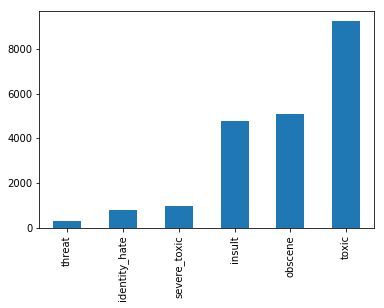

In [5]:
%matplotlib inline
train_samp.drop(["id","comment_text"], axis=1).sum().sort_values().plot(kind="bar");

explore resampling

maybe smarter to oversample after preprocessing using
[imbalanced learn](http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html)

In [4]:
def build_target(data):
    toxic_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    data["not_toxic"]  = data[toxic_cols].apply(lambda x: not any(x) , axis = 1)
    print("there are only", (1-data.not_toxic.mean())*100 ,"% of toxic comments")
    # build classification target: toxic if any
    return data.not_toxic

In [5]:
_ = build_target(train_samp)

there are only 10.2 % of toxic comments


In [7]:
import numpy as np
def compute_cap_ratio(string, tokenize=False):
    return np.sum([a.isupper() for a in string])/len(string)

from string import punctuation
def punct_ratio(string):
    c=0
    for char in punctuation:
        if char in string:
            c+=1
    return c/len(string)

def punct_sequences(string):
    seq = longest_seq = 0
    for char in string:
        if char in punctuation:
            seq+=1
        else:
            seq = 0
        if seq > longest_seq:
            longest_seq = seq
    return longest_seq

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sentiment_score(sentence):
    "use vader sentiment library (included in nltk)"
    
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(sentence)
    return scores["neg"], scores["neu"], scores["pos"]

def find_code(sentence):
        return len(re.findall(".{2,4}[^A-z0-9\.\s]{2,10}.{2,4}", sentence ))/len(sentence)

def build_basic_features(data):
    # capitalization ratio:
    data["cap_ratio"] = data.comment_text.map(lambda text: compute_cap_ratio(text))
    data["punct_ratio"] = data.comment_text.map(lambda text: punct_ratio(text))
    data["punct_series"] = data.comment_text.map(lambda text: punct_sequences(text))
    data["code_length"] = data.comment_text.map(lambda text: find_code(text))
    data["sentiment"] = data.comment_text.map(lambda text: sentiment_score(text))
    
    res = pd.DataFrame(list(data.comment_text.map(lambda text: sentiment_score(text))), columns=["neg", "neu", "pos"])
    data = pd.concat([data, res], axis=1)
    targets = ["toxic","severe_toxic", "obscene","threat", "insult", "identity_hate"]
    return data.drop(targets,axis = 1)

### Display a few examples

ideas:
---------
    - use sentiment lexicon and score text --done
    - externally train word2vec / use twitter glove github/3top/word2vec-api
    - use subwords information
    - use some distance based on word vectors
    - find base of insults, dead, nazis explore wordnet
    - design swaping letter distance better than levehnstein
    - clean data

In [10]:
%%time
feat = build_basic_features(train_samp)

CPU times: user 1min 26s, sys: 3.5 s, total: 1min 29s
Wall time: 31min 24s


In [28]:
pd.set_option("display.max_colwidth", 200)
train_samp.loc[train_samp.not_toxic==False,["not_toxic", "comment_text"]]

,not_toxic,comment_text
0,False,"Nonsense? kiss off, geek. what I said is true. I'll have your account terminated."
20,False,Why hasn't Alitalia been removed rom the alliance due to its piss-poor customer service? - Sentiments of nummerous FlyerTalkers
26,False,"""\nThe Graceful Slick....\nIs non other than an ungraceful dick!86.131.154.225 """
30,False,"""\n\n Stupid? \n\nAs soon as I saw the phrase """"metal is stupid"""" at the very beginning of the article, I assumed I misread it. When I confirmed that it did indeed say """"metal is stupid,"""" I then ..."
32,False,"""\nBan one side of an argument by a bullshit nazi admin and you get no discussion because the islamist editors feel they """"won""""."""
39,False,Are you gay?? Sound like it
62,False,and in the program on last night Crime Museum: The Blackout Ripper he is called a serial killer not only by experts but by the police who catched him !!!! so get your facts right you retards
79,False,"""\n\nI didn't call you a """"biased backward yank retard"""" I asked why you act like a """"biased backward yank retard"""" (which you do) there is a difference, and adding my comments to the talk page is..."
81,False,"""\n\nIt was very constructive you are just very very stupid. ARKJEDI10 """
86,False,"""\n\n You know what? Fuck you! I tried to be civil to you earlier, but since you're not gonna pay me the same courtesy there's no point. There's no need to poke fun at me using the word """"man"""" an..."


In [69]:
import seaborn as sns

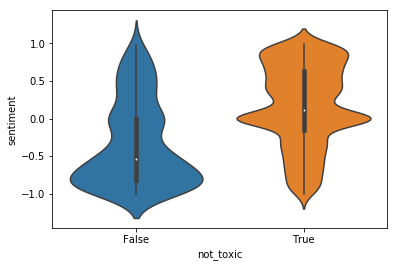

In [183]:
%matplotlib inline
sns.violinplot(x = feat.not_toxic ,y=feat.sentiment);

build a development set

In [184]:
from sklearn.tree import DecisionTreeClassifier

In [84]:
dtc = DecisionTreeClassifier()
dtc.fit(train_samp[["punct_ratio","cap_ratio","interaction"]], train_samp.not_toxic)
dtc.feature_importances_

array([ 0.29631517,  0.40119268,  0.30249215])

In [185]:
X = feat.drop('not_toxic',axis=1)
y = feat.not_toxic
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)

In [186]:
from sklearn.linear_model import LogisticRegression

In [187]:
lr = LogisticRegression()

In [188]:
lr.fit(X_train, y_train)
preds = lr.predict(X_dev)
probas = lr.predict_proba(X_dev)

In [189]:
from sklearn.metrics import accuracy_score, classification_report, log_loss

In [190]:
print(accuracy_score(y_pred=preds, y_true = y_dev))
print(log_loss(y_pred=probas, y_true = y_dev))

0.907
0.281309118029


In [ ]:
0.904
0.307

In [191]:
print(classification_report(y_pred=preds, y_true = y_dev))

             precision    recall  f1-score   support

      False       0.73      0.11      0.19       100
       True       0.91      1.00      0.95       900

avg / total       0.89      0.91      0.87      1000



In [170]:
analyzer = SentimentIntensityAnalyzer()

In [174]:
a = analyzer.polarity_scores("I hate tomatoes")

In [192]:
test, train = load_data(DATA_PATH, None)

In [195]:
from nltk import word_tokenize
words_test = test.comment_text.map(lambda x: len(word_tokenize(str(x))))

In [198]:
words_train = train.comment_text.map(lambda x: len(word_tokenize(str(x))))

In [203]:
words_test.sum(axis=0)

21737878

In [205]:
words_train.sum(axis=0)

7722434

In [206]:
import re

In [256]:
string = "==2006 (UTC)\n\n POV concerns \nI'm not (yet) going to put the NPOV warning up, but the statement ""Maher is also fair to his conservative guests"" is getting dangerously close to POV, since I'm s."
string2 ="— is wishing you a [WIKI_LINK: Mary Poppins@Merry] [WIKI_LINK: Christmas]! This greeting (and season) promotes [WIKI_LINK: Wikipedia:WikiLove@WikiLove] and hopefully this note has made your da..."

In [52]:
def clean_text(string):
    string = str(string).strip()
    #remove string beginning with 1/2 break line
    #replace break line inside text by . (new sentence)
    #remove string sarting with == 
    string = re.sub('"',"", string )
    string = re.sub('^\\n',"", string )
    string = re.sub('^\\n',"", string )
    string = re.sub('\\n+',". ", string )
    string = re.sub('=+$',"", string )
    string = re.sub('^=+',"", string )
    string = re.sub('^:+',"", string )
    string = re.sub('::+',"", string )
    string = re.sub('=+$',"", string )
    
    # deal with links and files
    string = re.sub("\[WIKI_LINK.+?\]", "WIKI_LINK", string)
    string = re.sub("\[EXTERNAL_LINK.+?\]", "EXTERNAL_LINK", string)
    string = re.sub("EXTERNAL_LINK|WIKI_LINK", "<URL>", string)
    string = re.sub("/https?:\/\/\S+\b|www\.(\w+\.)+\S*/","<URL>", string)
    string = re.sub('http.?:\/\/\S+',"<URL>", string)
    string = re.sub('(Image|File):+.+(jpg|png)',"<IMAGE>", string)
    string = re.sub('\S\.com',"", string)
    string = re.sub('/'," / ", string )
    return string

def clean_text_twitter(string):
    """preproce ss data in the same format than glove twitter
    see: https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb"""
    
    string = re.sub("/@\w+/", "<USER>", string)
    NOSE = "8|:|=|;"
    # deals with smiles
    string = re.sub("(?:"+NOSE+")(?:'|`|\||-)?(?:\)|d|p|\||\)|\(|\/|o|O|\$)",
                    "<SMILE>",
                    string,
                    flags=re.IGNORECASE)
            

In [266]:
print(clean_text("   ===fezfez== \n\njoi \n  "))
print(clean_text(string))
print(clean_text(string2))

fezfez== . joi
2006 (UTC).  POV concerns . I'm not (yet) going to put the NPOV warning up, but the statement Maher is also fair to his conservative guests is getting dangerously close to POV, since I'm s.
— is wishing you a LINK LINK! This greeting (and season) promotes LINK and hopefully this note has made your da...


In [267]:
string

"==2006 (UTC)\n\n POV concerns \nI'm not (yet) going to put the NPOV warning up, but the statement Maher is also fair to his conservative guests is getting dangerously close to POV, since I'm s."

In [270]:
test_samp

,id,comment_text
0,6044863,==Orphaned non-free media (Image:41cD1jboEvL. SS500 .jpg)==
1,6102620,"::Kentuckiana is colloquial. Even though the area is often referred to as this, it (in my opinion) has never held the encyclopedic precision of ""Louisville metropolitian area"", which has a specif..."
2,14563293,"Hello fellow Wikipedians,\nI have just modified on [WIKI_LINK: Double Trouble (George Jones and Johnny Paycheck album)]. Please take a moment to review [EXTERNAL_LINK: my edit]. If you have any q..."
3,21086297,"AKC Suspensions \nThe Morning Call - Feb 24, 2001 \n\n72.228.151.208"
4,22982444,== [WIKI_LINK: Talk:Celts] ==
5,24388733,Hello Xdes! [WIKI_LINK: Wikipedia:Introduction@Welcome] to Wikipedia! Thank you for . I think its very important for you to browse through some of the links below so as to become familiar with how...
6,26195914,"Hi there, I'm . I just wanted to let you know that [WIKI_LINK: Draft:Star-Spangled Banner Centennial Monument], a page you created, has not been edited in 6 months. The Articles for Creation spac..."
7,31769073,::I don't think a stuffed arm really counts as an appearance.
8,35289443,==Was it ever really a single in the UK?==
9,38393350,"Thanks for uploading [WIKI_LINK: Image:Cloudconquer.jpg]. However, there is a concern that the rationale you have provided for using this image under ""fair use"" may be invalid. Please read the ins..."


In [273]:
pd.DataFrame(test_samp.comment_text.map(lambda x: clean_text(x)))

,comment_text
0,Orphaned non-free media (Image:41cD1jboEvL. SS500 .jpg)
1,"Kentuckiana is colloquial. Even though the area is often referred to as this, it (in my opinion) has never held the encyclopedic precision of Louisville metropolitian area, which has a specific U..."
2,"Hello fellow Wikipedians,. I have just modified on WIKI_LINK. Please take a moment to review EXTERNAL_LINK. If you have any questions, or need the bot to ignore the links, or the page altogether,..."
3,"AKC Suspensions . The Morning Call - Feb 24, 2001 . 72.228.151.208"
4,WIKI_LINK
5,Hello Xdes! WIKI_LINK to Wikipedia! Thank you for . I think its very important for you to browse through some of the links below so as to become familiar with how Wikipedia works. If you need help...
6,"Hi there, I'm . I just wanted to let you know that WIKI_LINK, a page you created, has not been edited in 6 months. The Articles for Creation space is not an indefinite storage location for conten..."
7,I don't think a stuffed arm really counts as an appearance.
8,Was it ever really a single in the UK?
9,"Thanks for uploading WIKI_LINK. However, there is a concern that the rationale you have provided for using this image under fair use may be invalid. Please read the instructions at WIKI_LINK caref..."


In [281]:
pd.DataFrame(test_samp[100:200].comment_text.map(lambda x: clean_text(x)))

,comment_text
100,"Condemn all you want, the article was deleted because the subject is not notable, as they fail WP:GNG. Do not recreate until they have received significant independent coverage in reliable sourc..."
101,Hello! . –'''''' | Talk
102,"You're welcome. Also, remove the Friendly lines as well:. // START FRIENDLY. importScript('User:Ioeth/friendly.js');"
103,EXTERNAL_LINK. EXTERNAL_LINKEXTERNAL_LINKEXTERNAL_LINK. EXTERNAL_LINK. EXTERNAL_LINK. EXTERNAL_LINK. EXTERNAL_LINK. EXTERNAL_LINK. EXTERNAL_LINK. EXTERNAL_LINK. EXTERNAL_LINK. EXTERNAL_LINK. EXTER...
104,Fair use rationale for Image:Chichoni him.jpg
105,"You did, EXTERNAL_LINK."
106,"Your recent edit to WIKI_LINK (EXTERNAL_LINK) was reverted by an automated bot that attempts to recognize and repair WIKI_LINK to Wikipedia articles. If the bot reverted a legitimate edit, please ..."
107,"It wasn't an omission: I'd completed only about half of a huge load this week. It reminds me, that article topic is the next query ... email coming. (talk)"
108,"A page you started has been reviewed! . Thanks for creating Sanshin (deity), Seonookim! . Wikipedia editor just reviewed your page, and wrote this note for you:. Reviewed as part of page curation..."
109,I wish the Euro%74rash would stop fucking up Jewish articles. . Only Jews should be allowed to edit Jewish articles because the fucking anti-Semites who run Wikipedia can't be trusted.. Just look ...


In [282]:
string = re.sub('http.?:\/\/\S+',"", string)


In [283]:
string

'for your viewing pleasure:  86.43.216.73'

In [32]:
mapper = test_samp.comment_text.map(lambda x: clean_text(x)).map(lambda x: "|" in x)

In [33]:
pd.DataFrame(test_samp[mapper].comment_text.map(lambda x: clean_text(x)))

,comment_text
5,Hello Xdes! WIKI_LINK to Wikipedia! Thank you ...
13,couldnt find a map of the location of the empi...
101,Hello! . –'''''' | Talk
116,unblock|Material scientist isa dum dum and so ...
117,The EXTERNAL_LINK you made to WIKI_LINK consti...
118,This is your last warning. You will be blocke...
128,"Hello, and WIKI_LINK! We appreciate your contr..."
161,"ɱ{t{energy bracket|.w}.x}in route of:(f),(↔)+e"
170,| data11 = {{start and end dates|2011|05|10|...
189,in accordance with WIKI_LINK for . Once the bl...


In [14]:
from textblob import TextBlob

In [20]:

text =  test_samp.comment_text[19]
blob = TextBlob(text)


In [25]:
def extract_np(sentence)
    "extract noun phrases"
    blob = TextBlob(sentence)
    return list(blob.noun_phrases)

WordList(['ok', 'peace pipe', 'certain book'])

In [27]:
text

"Ok, let's get this peace pipe going (or I have to throw away a certain book I bought Friday). What's your purpose for those articles?"

In [46]:
def correct_mispelling(sentence):
    """ bad quality """
    blob = TextBlob(sentence)
    return str(blob.correct())

In [42]:
correct_mispelling(test_samp.comment_text[23])

"Thank you for unloading [WIKI_LINK: Image:Mud.if]. However, it currently is missing information on its copyright status. Wikipedia takes [WIKI_LINK: Wikipedia:Copyright@copyright] very seriously. It may be delete soon, unless we can determine the license and the source of the image. Of you know this information, then you can add a [WIKI_LINK: Wikipedia:Image copyright tags@copyright tag] to the [WIKI_LINK: Help:Image page@image description page].\nOf you have any questions, please feel free to ask them at the [WIKI_LINK: Wikipedia:Media copyright questions@media copyright questions page]. Thanks again for your cooperation. NOTE: once you correct this, please remove the tag from the image's page."